# Libraries

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Loading the DataSet

https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [122]:
gender = pd.read_csv("heart.csv")
balanced_dataset= gender.copy()
balanced_dataset.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Inspecting the Data

In [123]:
H=(balanced_dataset['output'].value_counts()[1])/(len(balanced_dataset))*100
print('percentage of more chance of heart attacks: ',H)
N=balanced_dataset['output'].value_counts()[0]/(len(balanced_dataset))*100
print('percentage of less chance of heart attacks: ',N)

percentage of more chance of heart attacks:  54.45544554455446
percentage of less chance of heart attacks:  45.54455445544555


Initially the dataset is almost balanced with a negligible ratio of imbalance.

<AxesSubplot:xlabel='output', ylabel='count'>

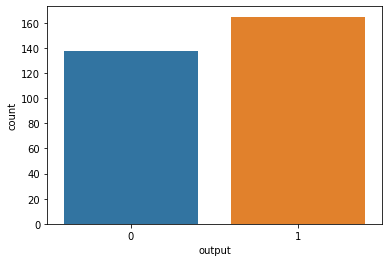

In [124]:
sns.countplot(x="output", data=balanced_dataset)

In [125]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Appeantly,there are no categorical features,all the columns contains numerical values.

In [126]:
balanced_dataset.shape

(303, 14)

DataSet has 14 columns and 303 rows.



In [127]:
print('Null Values in the dataset: ',balanced_dataset.isnull().sum().sum())

Null Values in the dataset:  0


No column contains the null values.

In [128]:
print('Duplicates in the dataset: ', balanced_dataset.duplicated().sum())

Duplicates in the dataset:  1


There is only one duplicate row in the dataset so we have to drop it in the pre-processing step.

# Visualizing the Data

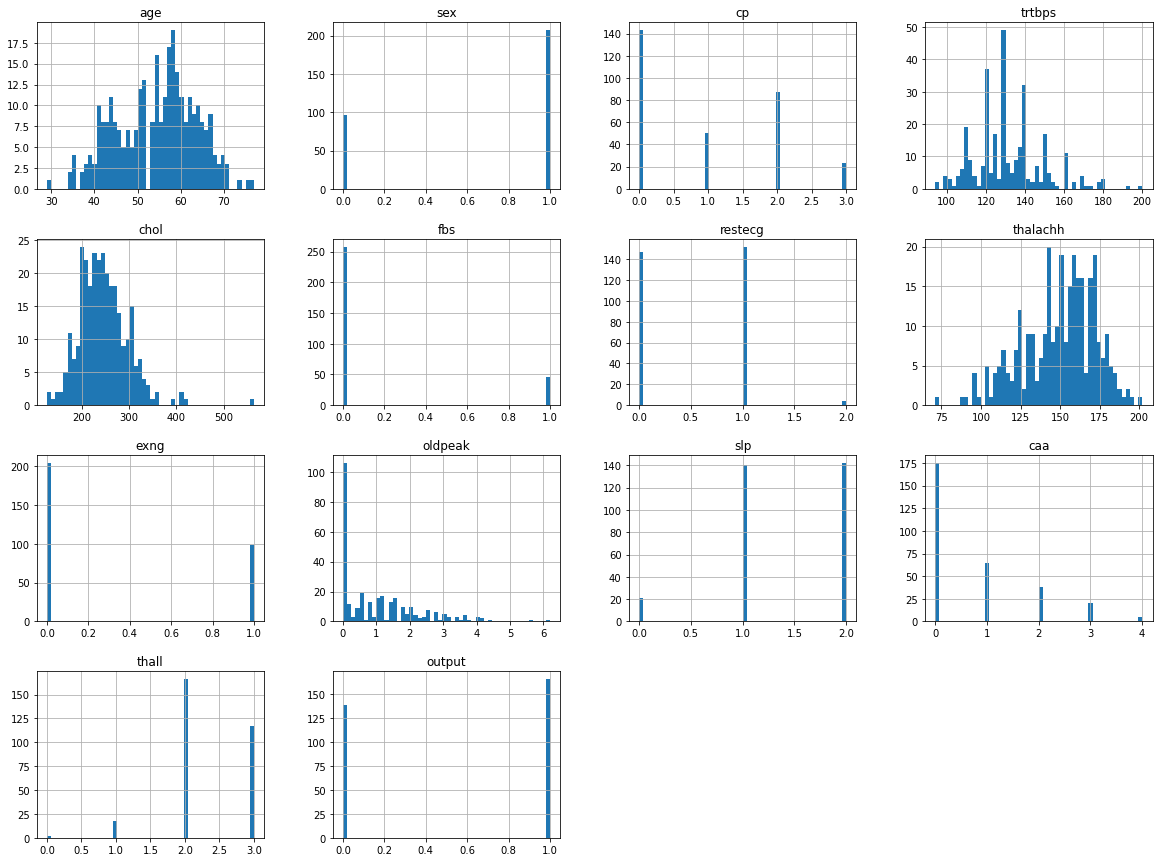

In [129]:
_ = balanced_dataset.hist(bins=50, figsize=(20,15))

'sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall' appear to be numerical features but they are categorical features.
For other features, it seems that data is skewed so there is a possibility of outliers present. We will explore this further in the next section.


In [130]:
numerical_features=['age','trtbps','chol','thalachh','oldpeak']
categorical_features=['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

# Exploring the Numerical Features

Lets visualize the numerical data with the help of boxplots to get some insights about outliers and quartiles.

<AxesSubplot:>

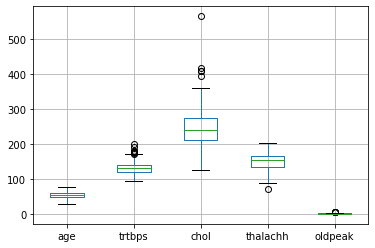

In [131]:
balanced_dataset[numerical_features].boxplot()

<AxesSubplot:xlabel='age'>

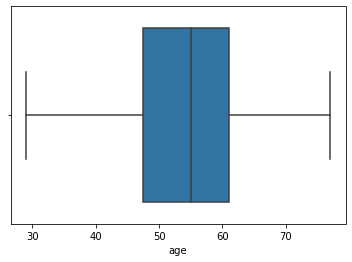

In [132]:
sns.boxplot(x='age', data=balanced_dataset)

Appearantly, the age feature has no outliers.

<AxesSubplot:xlabel='trtbps'>

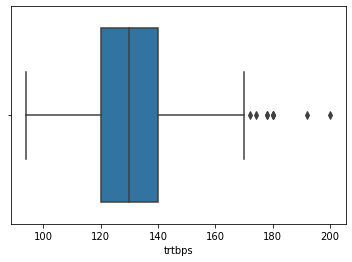

In [133]:
sns.boxplot(x='trtbps', data=balanced_dataset)

For trtbph(resting blood pressure) feature, there are 6 outliers whose value appear to be greater than 170.

<AxesSubplot:xlabel='chol'>

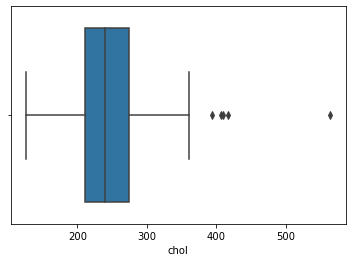

In [134]:
sns.boxplot(x='chol', data=balanced_dataset)

For cholesterol(chol), there are 5 outliers whose value appear to be greater than 360.

<AxesSubplot:xlabel='thalachh'>

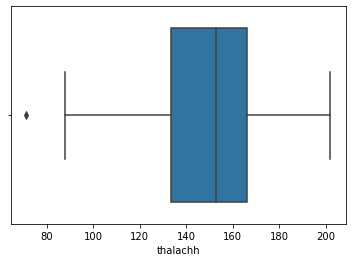

In [135]:
sns.boxplot(x='thalachh', data=balanced_dataset)

For feaure maximum heart rate achieved(thalachh), there is only one outlier whose value appear to be less than 75.

<AxesSubplot:xlabel='oldpeak'>

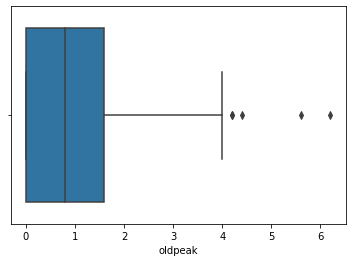

In [136]:
sns.boxplot(x='oldpeak', data=balanced_dataset)

For feature old peak, there are 4 outliers having value greater than 4.

Although outliers exist in our continuous data, but we are not going to remove them as those values are realistic values. For example, cholesterol reaching above 400 in very rare but it happens under different medical circumstances.

Lets, check the correlations among the numerical features with the help of a heat map.

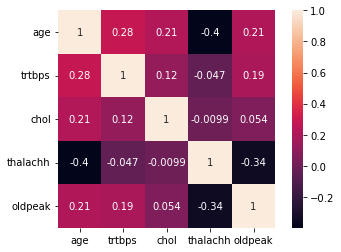

In [137]:
corr = balanced_dataset[numerical_features].corr()
sns.heatmap(corr, annot=True, square=True)
plt.yticks(rotation=0)
plt.show()

Thalachh(max heart rate achieved) has a weak negative correlation with all other features.
While oldpeak, cholesterol, trtbps(resting bloodpressure) and age have weak positive correlations among each other.
We can verify this through relational plots.

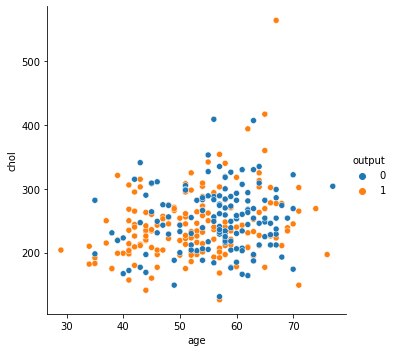

In [138]:
sns.relplot(x='age', y='chol', hue='output', data=balanced_dataset)

The above graph gives no significant insights about the relation between chol and age because both are weakly corelated as discussed earlier.

# Exploring the Categorical Features

Displaying the distribution of categorical features among both classes in terms of percentage.

https://medium.com/swlh/how-to-create-percentage-plots-for-visualizing-your-data-in-python-f0d894d7c7bb

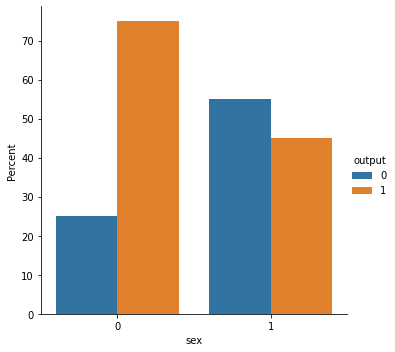

In [139]:
df_temp = balanced_dataset.groupby('sex')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='sex', y='Percent', hue='output', kind='bar', data=df_temp)

Insight from above graph: Chances of heart attack in females(0) is higher than males(1).

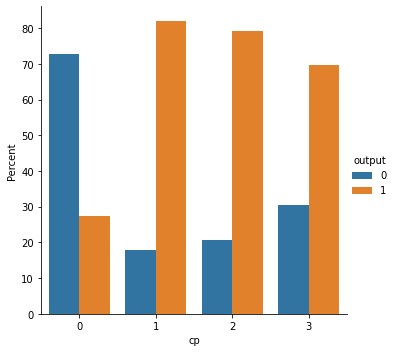

In [140]:
df_temp = balanced_dataset.groupby('cp')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='cp', y='Percent', hue='output', kind='bar', data=df_temp)

Insight: Chances of heartattack are high with chest pains (atypical angina(1), non-anginal pain(2) and asympmtomatic pain(3)).

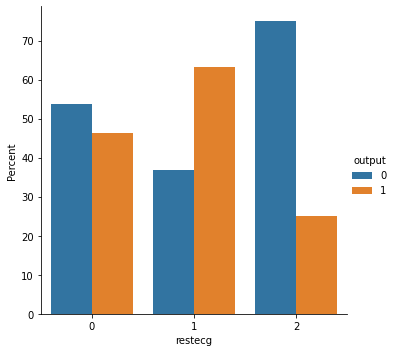

In [141]:
df_temp = balanced_dataset.groupby('restecg')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='restecg', y='Percent', hue='output', kind='bar', data=df_temp)

With Restingelectrocardiographic results of type1, chances of heartattack are high, with type 0 they are moderate while with type 2 they are really low.

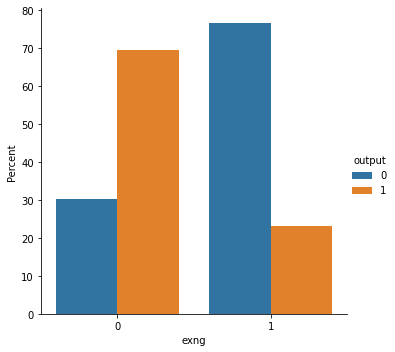

In [142]:
df_temp = balanced_dataset.groupby('exng')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='exng', y='Percent', hue='output', kind='bar', data=df_temp)

Surprisingly, with Exercise Induced Angina, chances of heartattack are low.

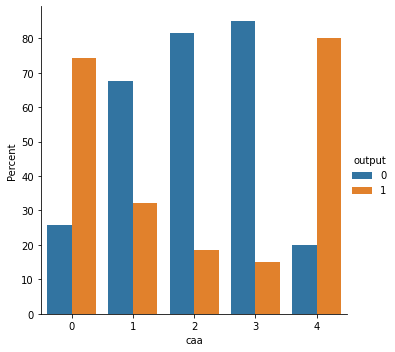

In [143]:
df_temp = balanced_dataset.groupby('caa')['output'].value_counts(normalize=True)
df_temp = df_temp.mul(100).rename('Percent').reset_index()
sns.catplot(x='caa', y='Percent', hue='output', kind='bar', data=df_temp)

People with 0 and 4 major vessels have more chances of getting a heart attack.

# Data pre-processing

In [144]:
print("Number of rows before dropping duplicates: %d" % len(balanced_dataset))
balanced_dataset= balanced_dataset.drop_duplicates()
print("Number of rows after dropping duplicates: %d" % len(balanced_dataset))

Number of rows before dropping duplicates: 303
Number of rows after dropping duplicates: 302


As visualized earlier, they was 1 duplicate rows in the dataset so we have removed it.

As, we are going to perform random forest in our baseline model, so no feature scaling or features reduction is required.

In [145]:
X_balanced_dataset=balanced_dataset.drop(columns=['output'])
Y_balanced_dataset=balanced_dataset['output'].copy()

# Creating a Surrogate achieving low Imbalance

In [146]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=88, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_low=pd.concat([M, L])
Imbalanced_dataset_low.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [147]:
M=(Imbalanced_dataset_low['output'].value_counts()[1])/(len(Imbalanced_dataset_low))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_low['output'].value_counts()[0]/(len(Imbalanced_dataset_low))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  65
percentage of output with less chances of heartattack:  35


<AxesSubplot:xlabel='output', ylabel='count'>

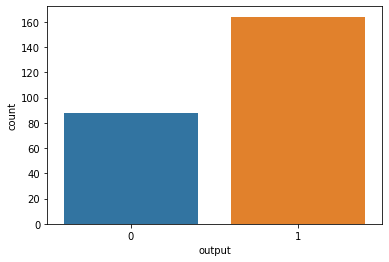

In [148]:
sns.countplot(x="output", data=Imbalanced_dataset_low)

In [149]:
Imbalanced_dataset_low.shape

(252, 14)

Low Surrogate dataset has 252 rows and same number of columns as in balanced dataset.

In [150]:
print('Duplicates in the dataset: ', Imbalanced_dataset_low.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [151]:
X_Imbalanced_dataset_low=Imbalanced_dataset_low.drop(columns=['output'])
Y_Imbalanced_dataset_low=Imbalanced_dataset_low['output'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving Medium Imbalance

In [152]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=54, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_med=pd.concat([M, L])
Imbalanced_dataset_med.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [153]:
M=(Imbalanced_dataset_med['output'].value_counts()[1])/(len(Imbalanced_dataset_med))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_med['output'].value_counts()[0]/(len(Imbalanced_dataset_med))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  75
percentage of output with less chances of heartattack:  25


<AxesSubplot:xlabel='output', ylabel='count'>

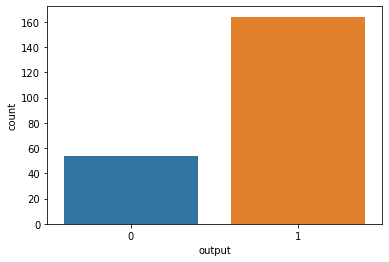

In [154]:
sns.countplot(x="output", data=Imbalanced_dataset_med)

In [155]:
Imbalanced_dataset_med.shape

(218, 14)

Med Surrogate dataset has 218 rows and same number of columns as in balanced dataset.

In [156]:
print('Duplicates in the dataset: ', Imbalanced_dataset_med.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [157]:
X_Imbalanced_dataset_med=Imbalanced_dataset_med.drop(columns=['output'])
Y_Imbalanced_dataset_med=Imbalanced_dataset_med['output'].copy()

Features and target label are separated in the above piece of code.

# Creating a Surrogate achieving High Imbalance

In [158]:
L=balanced_dataset[balanced_dataset['output'] == 0] 
M=balanced_dataset[balanced_dataset['output'] == 1] #majority class more chances of heartattack represented by 1
L= L.sample(replace=False,  n=18, random_state=1) #minority class less chances of heartattack represented by 0
Imbalanced_dataset_high=pd.concat([M, L])
Imbalanced_dataset_high.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [159]:
M=(Imbalanced_dataset_high['output'].value_counts()[1])/(len(Imbalanced_dataset_high))*100
print('percentage of output with more chances of heart attack: ',round(M))
L=Imbalanced_dataset_high['output'].value_counts()[0]/(len(Imbalanced_dataset_high))*100
print('percentage of output with less chances of heartattack: ',round(L))

percentage of output with more chances of heart attack:  90
percentage of output with less chances of heartattack:  10


<AxesSubplot:xlabel='output', ylabel='count'>

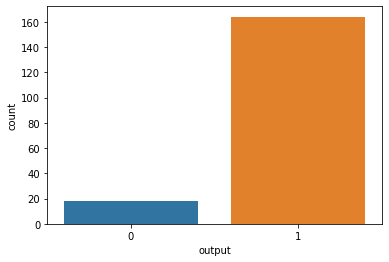

In [160]:
sns.countplot(x="output", data=Imbalanced_dataset_high)

In [161]:
Imbalanced_dataset_high.shape

(182, 14)

Med Surrogate dataset has 182 rows and same number of columns as in balanced dataset.

In [162]:
print('Duplicates in the dataset: ', Imbalanced_dataset_high.duplicated().sum())

Duplicates in the dataset:  0


Duplicates are checked to ensure that there was no duplication while randomly sub-sampling from the e class.

In [163]:
X_Imbalanced_dataset_high=Imbalanced_dataset_high.drop(columns=['output'])
Y_Imbalanced_dataset_high=Imbalanced_dataset_high['output'].copy()

Features and target label are separated in the above piece of code.